In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import pandas as pd

In [3]:
from weighted_svd_utils import weighted_svd_inverse_weight, WeightedSVD, get_svd, weighted_frobenious, rank_r, toy_seven_subspace_matrix

## Weighted SVD inverse weight

In [30]:
mat = toy_seven_subspace_matrix(inp=400, out=700)
# mat = torch.randn(300, 600)
# mat = torch.randn(700, 400)

In [31]:
weights = torch.randn(700, 400).abs()
# weights = torch.ones_like(mat)
# weights = torch.ones_like(mat) * (torch.arange(mat.shape[0]).view(-1,1)+1)
# weights = torch.ones_like(mat)

In [32]:
U, S, V = weighted_svd_inverse_weight(mat, weights)

In [33]:
sig_val_losses = []
actual_losses = []
for i in range(1, 400):
    sig_val_loss = torch.sqrt(weighted_frobenious(mat, U@rank_r(S, 400)@V.T, weights)**2 + (S[i:]**2).sum()).item()
    actual_loss = weighted_frobenious(mat, U@rank_r(S, i)@V.T, weights).item()
    sig_val_losses.append(sig_val_loss)
    actual_losses.append(actual_loss)

<Axes: xlabel='rank'>

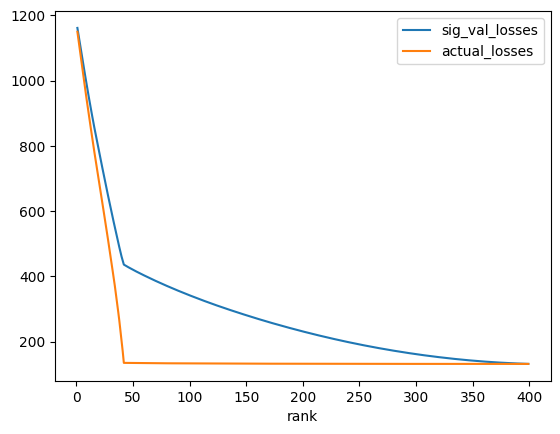

In [34]:
pd.DataFrame(dict(sig_val_losses=sig_val_losses, actual_losses=actual_losses, rank=range(1,400))).set_index("rank").plot()

## Projection loss diff of WeightedSVD and weighted_svd_inverse_weight

In [17]:
mat = torch.randn(300, 600)

In [18]:
weights = torch.randn(300, 600).abs()

In [19]:
projection_loss_inverse_weight = []
projection_loss_gd = []
for i in range(10, 301, 10):
    U, S, V = weighted_svd_inverse_weight(mat, weights)
    projection_loss_inverse_weight.append(
        # rank i
        weighted_frobenious(mat, (U@rank_r(S, i))@V.T, weights).item()
    )
    weighted_svd = WeightedSVD(mat, weights, rank=i)
    U, S, V = weighted_svd.fit(iters=2400, lr=0.1, lambd=0.0)
    projection_loss_gd.append(
        # rank i
        weighted_frobenious(mat, (U@rank_r(S, i))@V.T, weights).item()
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:06<00:00, 382.20it/s]


In [20]:
df = pd.DataFrame(dict(projection_loss_inverse_weight=projection_loss_inverse_weight, projection_loss_gd=projection_loss_gd, rank=list(range(10, 301, 10))))

<Axes: xlabel='rank'>

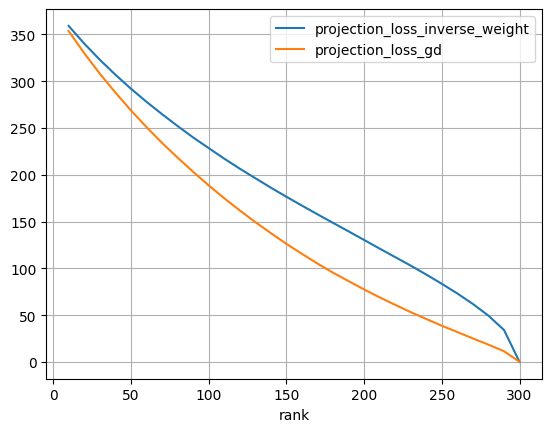

In [21]:
df.set_index("rank").plot(grid=True)

In [22]:
df

,projection_loss_inverse_weight,projection_loss_gd,rank
0,359.081696,353.629852,10
1,340.260345,330.026489,20
2,323.023895,308.155396,30
3,307.050812,288.017365,40
4,292.057068,268.949463,50
5,278.083069,251.122223,60
6,264.840179,234.189453,70
7,252.186554,218.445236,80
8,239.988632,203.255005,90
9,228.602402,188.776016,100


In [23]:
df["diff"] = df.projection_loss_inverse_weight - df.projection_loss_gd

<Axes: xlabel='rank'>

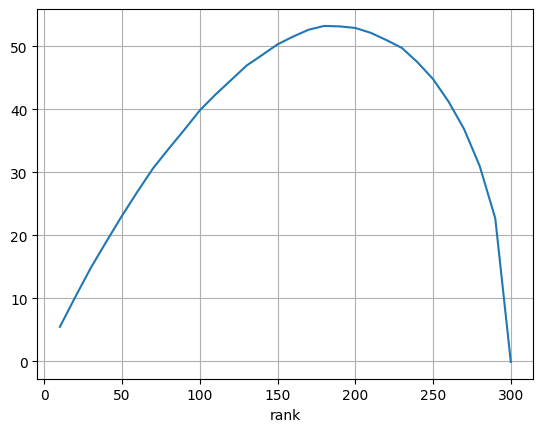

In [24]:
df.set_index("rank")["diff"].plot(grid=True)